In [19]:
# Cell 1: Imports and dataset paths
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

BASE_DIR = "/content/brain_tumor_dataset"
YES_DIR = os.path.join(BASE_DIR, "yes")
NO_DIR  = os.path.join(BASE_DIR, "no")

print("Dataset folders set:")
print(" YES:", YES_DIR)
print(" NO :", NO_DIR)


Dataset folders set:
 YES: /content/brain_tumor_dataset/yes
 NO : /content/brain_tumor_dataset/no


In [20]:
def show_gray(img, title=""):
    plt.imshow(img, cmap='gray'); plt.title(title); plt.axis('off')

def log_transform(img):
    img_f = img.astype(np.float64)
    c = 255.0 / np.log(1 + np.max(img_f))
    out = c * np.log(1 + img_f)
    return np.uint8(np.clip(out,0,255))

def gamma_transform(img, gamma=0.6):
    img_n = img.astype(np.float32) / 255.0
    out = (img_n ** gamma) * 255.0
    return np.uint8(np.clip(out,0,255))

def hist_eq(img):
    return cv2.equalizeHist(img)

def clahe_transform(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

def canny_edges(img):
    return cv2.Canny(img,100,200)

print("IVP functions loaded.")


IVP functions loaded.


In [21]:
yes_images = sorted(glob.glob(os.path.join(YES_DIR, "*.*")))
no_images  = sorted(glob.glob(os.path.join(NO_DIR, "*.*")))
print("Found images -> Tumor (yes):", len(yes_images), "No-tumor (no):", len(no_images))

# quick sanity show first 3 filenames (if any)
for i,p in enumerate(yes_images[:3]): print(" yes", i, ":", os.path.basename(p))
for i,p in enumerate(no_images[:3]):  print(" no ", i, ":", os.path.basename(p))


Found images -> Tumor (yes): 155 No-tumor (no): 98
 yes 0 : Y1.jpg
 yes 1 : Y10.jpg
 yes 2 : Y100.JPG
 no  0 : 1 no.jpeg
 no  1 : 10 no.jpg
 no  2 : 11 no.jpg


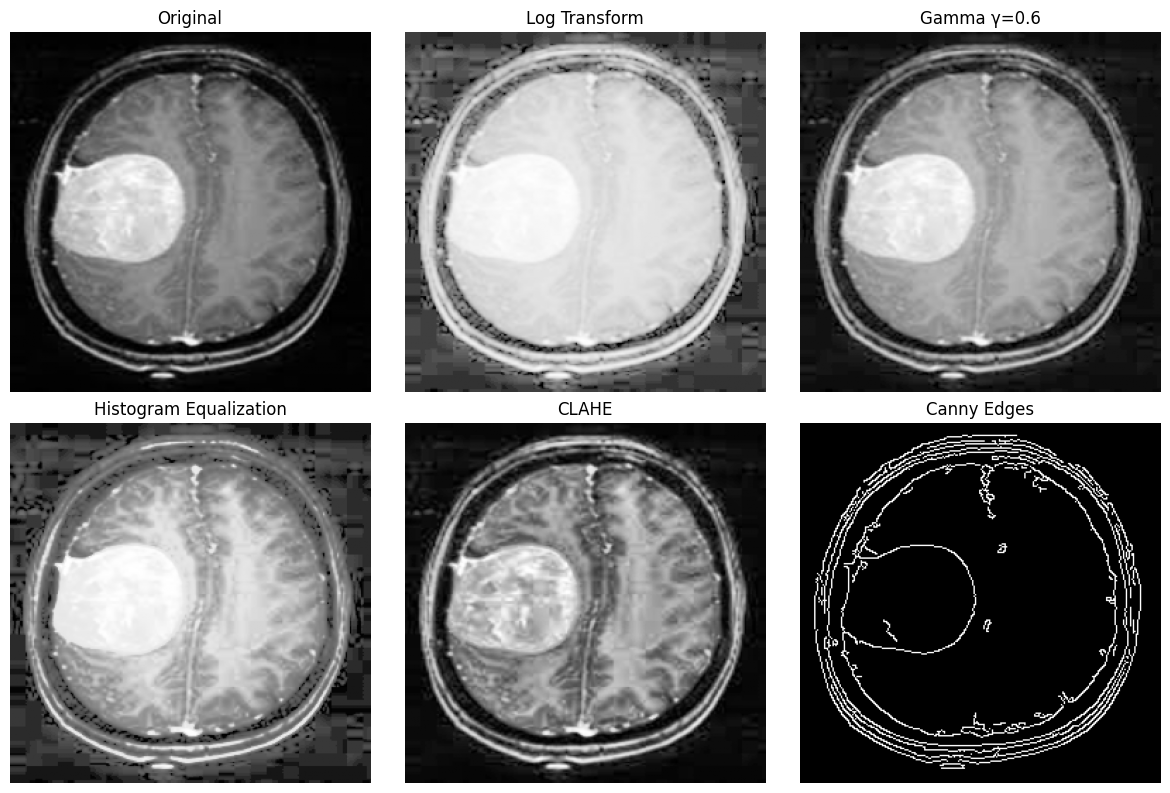

In [22]:
sample = yes_images[0]
img = cv2.imread(sample)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (256,256))

plt.figure(figsize=(12,8))
plt.subplot(2,3,1); show_gray(gray, "Original")
plt.subplot(2,3,2); show_gray(log_transform(gray), "Log Transform")
plt.subplot(2,3,3); show_gray(gamma_transform(gray, 0.6), "Gamma γ=0.6")
plt.subplot(2,3,4); show_gray(hist_eq(gray), "Histogram Equalization")
plt.subplot(2,3,5); show_gray(clahe_transform(gray), "CLAHE")
plt.subplot(2,3,6); show_gray(canny_edges(gray), "Canny Edges")
plt.tight_layout(); plt.show()


In [18]:
!unzip -q "/content/archive (3).zip" -d "/content/brain_tumor_dataset"


In [23]:
# Small helper cell: find a zip, extract images and sort into yes/no folders automatically.
import os, glob, zipfile, shutil
from pathlib import Path

ROOT = Path("/content")
TARGET = ROOT / "brain_tumor_dataset"
YES_DIR = TARGET / "yes"
NO_DIR  = TARGET / "no"
UNKNOWN_DIR = TARGET / "unknown"
TMP_EXTRACT = ROOT / "tmp_extracted_dataset"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

os.makedirs(YES_DIR, exist_ok=True)
os.makedirs(NO_DIR, exist_ok=True)
os.makedirs(UNKNOWN_DIR, exist_ok=True)
if TMP_EXTRACT.exists():
    shutil.rmtree(TMP_EXTRACT)
os.makedirs(TMP_EXTRACT, exist_ok=True)

# Find first zip file under /content (including subfolders)
zip_candidates = sorted(glob.glob(str(ROOT / "**" / "*.zip"), recursive=True))
if not zip_candidates:
    print("No .zip files found under /content. If you already uploaded folder, skip this cell and run the dataset-check cell.")
else:
    z = zip_candidates[0]
    print("Unzipping:", z, "->", TMP_EXTRACT)
    try:
        with zipfile.ZipFile(z, 'r') as zf:
            zf.extractall(str(TMP_EXTRACT))
        print("Unzip completed.")
    except Exception as e:
        print("Unzip failed:", e)
        raise

# Walk extracted tree and move images to yes/no/unknown
moved = {"yes":0, "no":0, "unknown":0}
confident_keywords_yes = {"yes","tumor","positive"}
confident_keywords_no  = {"no","notumor","negative","normal","healthy","not_tumor","nontumor"}

def decide_label_from_path(p: Path):
    # Check each path component for keywords
    lower_parts = [part.lower() for part in p.parts]
    for part in lower_parts[::-1]:  # check filename first then parents
        for kw in confident_keywords_yes:
            if kw in part:
                return "yes"
        for kw in confident_keywords_no:
            if kw in part:
                return "no"
    # fallback: check filename tokens
    name = p.stem.lower()
    for kw in confident_keywords_yes:
        if kw in name: return "yes"
    for kw in confident_keywords_no:
        if kw in name: return "no"
    return None

def unique_target_path(dest_dir: Path, filename: str):
    dest = dest_dir / filename
    if not dest.exists():
        return dest
    base = Path(filename).stem
    ext = Path(filename).suffix
    i = 1
    while True:
        cand = dest_dir / f"{base}_{i}{ext}"
        if not cand.exists():
            return cand
        i += 1

# find all image files
all_images = []
for ext in IMG_EXTS:
    all_images.extend(sorted(TMP_EXTRACT.rglob(f"*{ext}")))
all_images = [Path(p) for p in all_images]

print(f"Found {len(all_images)} image files in the extracted archive.")

unknown_examples = []
for p in all_images:
    label = decide_label_from_path(p)
    if label == "yes":
        dest = unique_target_path(YES_DIR, p.name)
        shutil.copy2(p, dest)
        moved["yes"] += 1
    elif label == "no":
        dest = unique_target_path(NO_DIR, p.name)
        shutil.copy2(p, dest)
        moved["no"] += 1
    else:
        dest = unique_target_path(UNKNOWN_DIR, p.name)
        shutil.copy2(p, dest)
        moved["unknown"] += 1
        if len(unknown_examples) < 10:
            unknown_examples.append(str(p))

print("\nMove complete. Summary:")
print("  yes  ->", moved["yes"], "files ->", YES_DIR)
print("  no   ->", moved["no"], "files ->", NO_DIR)
print("  unknown ->", moved["unknown"], "files ->", UNKNOWN_DIR)

if moved["unknown"] > 0:
    print("\nExamples of 'unknown' files (first 10):")
    for ex in unknown_examples:
        print(" ", ex)
    print("\nIf many files ended up in unknown, inspect the filenames or parent folders and rename them to include 'yes' or 'no' or move them manually into the yes/no folders.")

# Final counts check
yes_count = len(list(YES_DIR.glob("*.*")))
no_count = len(list(NO_DIR.glob("*.*")))
unknown_count = len(list(UNKNOWN_DIR.glob("*.*")))
print(f"\nFinal counts in target folders: yes={yes_count}, no={no_count}, unknown={unknown_count}")

# Cleanup temp if you want (uncomment to remove)
# shutil.rmtree(TMP_EXTRACT)
print("\nDone. Now re-run your Cell 3 (file listing) and then Cell 4 (demo).")


Unzipping: /content/archive (3).zip -> /content/tmp_extracted_dataset
Unzip completed.
Found 358 image files in the extracted archive.

Move complete. Summary:
  yes  -> 174 files -> /content/brain_tumor_dataset/yes
  no   -> 184 files -> /content/brain_tumor_dataset/no
  unknown -> 0 files -> /content/brain_tumor_dataset/unknown

Final counts in target folders: yes=329, no=282, unknown=0

Done. Now re-run your Cell 3 (file listing) and then Cell 4 (demo).


In [24]:
import os

# List the contents of the base directory
print("Contents of '/content/brain_tumor_dataset':")
for root, dirs, files in os.walk('/content/brain_tumor_dataset'):
    level = root.replace('/content/brain_tumor_dataset', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')


Contents of '/content/brain_tumor_dataset':
brain_tumor_dataset/
    unknown/
    no/
        3 no_1.jpg
        20 no_2.jpg
        39 no_2.jpg
        42 no_2.jpg
        no 6_1.jpg
        No11_2.jpg
        13 no_2.jpg
        No18_2.jpg
        No17_2.jpg
        No22_2.jpg
        no 90_2.jpg
        No19.jpg
        No20.jpg
        9 no.jpg
        N15_1.jpg
        no 5_2.jpeg
        N6_2.jpg
        No14_2.jpg
        35 no.jpg
        30 no_1.jpg
        35 no_1.jpg
        10 no_1.jpg
        N3_1.jpg
        No18.jpg
        no 923_2.jpg
        25 no.jpg
        40 no_1.jpg
        No15.jpg
        12 no.jpg
        46 no.jpg
        29 no_2.jpg
        N16_2.jpg
        37 no_2.jpg
        No12_2.jpg
        no 4.jpg
        27 no_2.jpg
        31 no_2.jpg
        13 no.jpg
        14 no.jpg
        N17_1.jpg
        19 no_2.jpg
        5 no.jpg
        38 no_2.jpg
        15 no_2.jpg
        no 9.png
        no 89_2.jpg
        13 no_1.jpg
        45 no_2.jpg
        5

This will show us the folder structure. Once we see the structure, we can adjust the `BASE_DIR`, `YES_DIR`, and `NO_DIR` variables in Cell 1 if needed, or identify if the files are missing altogether.

In [25]:
# Cell 5: Load images into arrays
IMG_SIZE = 128
X = []; y = []

def load_and_preprocess(path, label):
    im = cv2.imread(path)
    g = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    g = cv2.resize(g, (IMG_SIZE, IMG_SIZE))
    g = clahe_transform(g)
    X.append(g); y.append(label)

for p in yes_images: load_and_preprocess(p, 1)
for p in no_images:  load_and_preprocess(p, 0)

X = np.array(X, dtype=np.float32) / 255.0
X = X[..., np.newaxis]   # (N, H, W, 1)
y = np.array(y, dtype=np.int32)

print("Prepared data shape:", X.shape, "labels:", y.shape)


Prepared data shape: (253, 128, 128, 1) labels: (253,)


In [26]:
import os

# Ensure the target directory exists
if not os.path.exists('/content/brain_tumor_dataset'):
    os.makedirs('/content/brain_tumor_dataset')

# Unzip the archive (replace 'archive (3).zip' with the actual filename if different)
!unzip -q "archive (3).zip" -d "/content/brain_tumor_dataset"

print("Archive unzipped to /content/brain_tumor_dataset/")


replace /content/brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive unzipped to /content/brain_tumor_dataset/


In [27]:
# Cell 6: Train/val split and model definition
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train samples:", X_train.shape[0], "Val samples:", X_val.shape[0])

model = models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Train samples: 202 Val samples: 51


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Cell 7: Train the CNN (use GPU runtime if available)
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val,y_val), callbacks=[es], verbose=1)

# Save model and history artifacts
os.makedirs("/content/outputs", exist_ok=True)
model.save("/content/outputs/best_model.h5")
print("Model saved to /content/outputs/best_model.h5")


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 837ms/step - accuracy: 0.5350 - loss: 0.7120 - val_accuracy: 0.7451 - val_loss: 0.5764
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 882ms/step - accuracy: 0.7963 - loss: 0.5252 - val_accuracy: 0.7255 - val_loss: 0.5360
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 964ms/step - accuracy: 0.7987 - loss: 0.5093 - val_accuracy: 0.7451 - val_loss: 0.5234
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 782ms/step - accuracy: 0.8301 - loss: 0.4423 - val_accuracy: 0.7647 - val_loss: 0.4863
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 980ms/step - accuracy: 0.8294 - loss: 0.4206 - val_accuracy: 0.7451 - val_loss: 0.4685
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.8005 - loss: 0.4170 - val_accuracy: 0.8627 - val_loss: 0.4628
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 797ms/step - accuracy: 0.8874 - loss: 0.3081 - val_accuracy: 0.8235 - val_loss: 0.4233
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 835ms/step - accuracy: 0.8702 - loss: 0.2870 - val_accuracy: 0.8431 - val_lo

Model saved to /content/outputs/best_model.h5


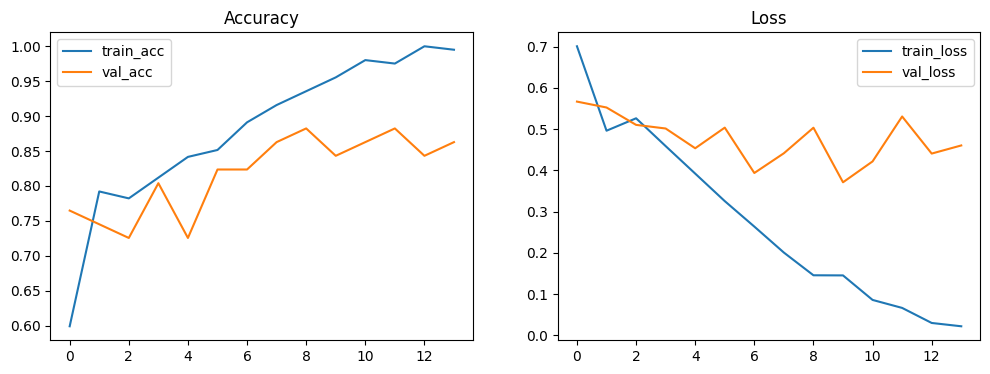

Accuracy: 0.8431372549019608
Precision: 0.9259259259259259
Recall: 0.8064516129032258
F1: 0.8620689655172413
ROC-AUC: 0.932258064516129


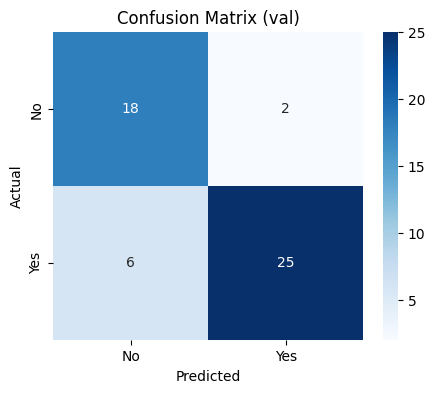

Saved /content/outputs/val_predictions.csv


In [11]:
# Cell 8: Plot training curves and show basic metrics (requires history and X_val/y_val)
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Plot curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss"); plt.legend()
plt.show()

# Predictions on validation set
y_prob = model.predict(X_val, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
try:
    print("ROC-AUC:", roc_auc_score(y_val, y_prob))
except:
    pass

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix (val)"); plt.show()

# Save CSV of predictions
import pandas as pd
os.makedirs("/content/outputs", exist_ok=True)
pd.DataFrame({'y_true':y_val, 'y_prob':y_prob, 'y_pred':y_pred}).to_csv("/content/outputs/val_predictions.csv", index=False)
print("Saved /content/outputs/val_predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Y100.JPG -> No Tumor (prob=0.496)


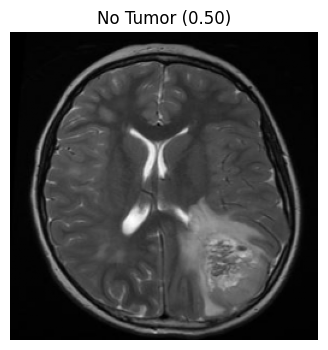

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
11 no.jpg -> No Tumor (prob=0.201)


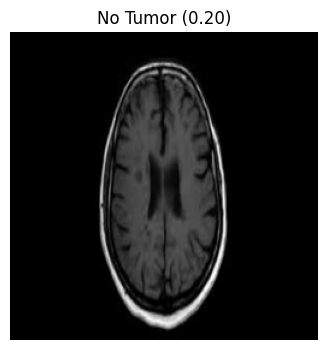

In [30]:


def demo_predict(path):
    im = cv2.imread(path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    display = cv2.resize(gray, (256,256))
    inp = cv2.resize(gray, (IMG_SIZE,IMG_SIZE)).astype('float32')/255.0
    prob = model.predict(inp[np.newaxis,...,np.newaxis])[0][0]
    label = "Tumor" if prob>=0.5 else "No Tumor"
    print(f"{os.path.basename(path)} -> {label} (prob={prob:.3f})")
    plt.figure(figsize=(4,4)); show_gray(display, f"{label} ({prob:.2f})"); plt.show()

# Example usage (change indices as you prefer)
demo_predict(yes_images[2])
demo_predict(no_images[2])
